In [77]:
import torchvision 
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset,DataLoader
import math
import os
from PIL import Image
from torchvision import transforms

In [78]:
class FSRCNN_data(Dataset):
    def __init__(self,image_dir,transform=None):

        self.image_dir=image_dir
        self.image_list=os.listdir(image_dir)
        self.transform=transform
        
      

    def __getitemimage__(self,index):
        
        image_path=os.path.join(self.image_dir,self.image_list[2*index+1])
        image = Image.open(image_path)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True)
        ])
        image = transform(image)
        
        mean = torch.Tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.Tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = (image - mean) / std
        
        return image
        
    def __getitemlabel__(self,index):
        
        
        label_path=os.path.join(self.image_dir,self.image_list[2*index])
        label = Image.open(label_path)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True)
        ])
        label = transform(label)
        
        mean = torch.Tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.Tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        label = (label - mean) / std
        return label
        

    def __len__(self):
        return len(self.image_list)

    def plot_image(self, index):
        input_image, target_image = self.__getitem__(index)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        ax1.imshow(input_image)
        ax1.set_title('Input (Low Resolution)')
        ax1.axis('off')
        
        ax2.imshow(target_image)
        ax2.set_title('Target (High Resolution)')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        

In [79]:
dataset=FSRCNN_data('BSD100/image_SRF_2')

In [80]:
x=dataset.__getitemlabel__(94)
print(x.shape)
print(x.max())



torch.Size([3, 224, 224])
tensor(2.6193)


In [81]:
x=dataset.__getitemimage__(94)
print(x.shape)
print(x.max())


torch.Size([3, 224, 224])
tensor(2.6241)


In [ ]:

for i in range(4):
   
    dataset.plot_image(i)



In [82]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional



In [83]:
class SRCNN_model(nn.Module):
    def __init__(self):
        super(SRCNN_model,self). __init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=9,padding=4)
        self.relu1=nn.ReLU()
        self.conv2=nn.Conv2d(64,32,1,padding=0)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(32,3,5,padding=2)
    def forward(self,X):
        X=self.conv1(X)
        X=self.relu1(X)
        X=self.conv2(X)
        X=self.relu2(X)
        X=self.conv3(X)
        return X
        
        
        
        
        

In [84]:
#VGG-16 model
import torchvision.models as models

class VGGperceptualLoss(nn.Module):
    
    def __init__(self):
        super(VGGperceptualLoss,self).__init__()
        
        vgg=models.vgg16(pretrained=True).features.eval()
        
        self.vgg_layers=nn.ModuleList(vgg)
        self.layer_name_mapping={
            '3':"relu1_2",
            '8':"relu2_2",
            '15':"relu3_3",
            '22':"relu4_3"          
        }
    def forward(self,x,y):   
        x_vgg,y_vgg=x,y
        loss=0
        
        for name,module in self.vgg_layers._modules.items():
            x_vgg=module(x_vgg)
            y_vgg=module(y_vgg)
            if name in self.layer_name_mapping:
                loss+=nn.functional.l1_loss(x_vgg,y_vgg)
        return loss
        


Epoch 0, Loss: 0.4393615736067295
Epoch 1, Loss: 0.2596836518496275
Epoch 2, Loss: 0.19912589997053146
Epoch 3, Loss: 0.17578778594732283
Epoch 4, Loss: 0.16754897713661193
Epoch 5, Loss: 0.14526578780263663
Epoch 6, Loss: 0.14483779702335597
Epoch 7, Loss: 0.1347179564833641
Epoch 8, Loss: 0.12454719264060259
Epoch 9, Loss: 0.13009430326521396
Epoch 10, Loss: 0.11506353124976158
Epoch 11, Loss: 0.11028306953608989
Epoch 12, Loss: 0.11439725119620561
Epoch 13, Loss: 0.1083372600749135
Epoch 14, Loss: 0.10399985827505588
Epoch 15, Loss: 0.10018364809453488
Epoch 16, Loss: 0.09843611232936382
Epoch 17, Loss: 0.10080659713596106
Epoch 18, Loss: 0.108249188400805
Epoch 19, Loss: 0.12180034063756466


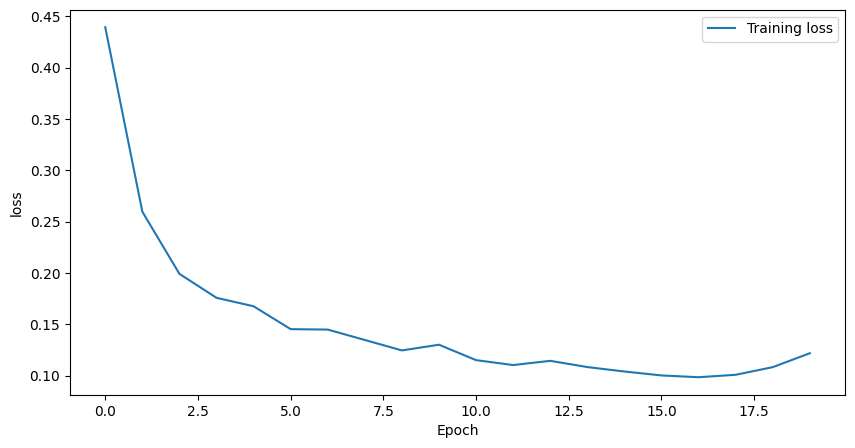

In [85]:
model=SRCNN_model()
mse_loss=nn.MSELoss()
perceptual_loss=VGGperceptualLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

epochs=20
batch_size=1
training_loss=[]

for i in range(epochs):
    running_loss=0.0
    for j in range(100):
        
        images=dataset.__getitemimage__(j)
        labels=dataset.__getitemlabel__(j)
        optimizer.zero_grad()
        outputs=model(images)
        mse=mse_loss(outputs,labels)
        perceptual=perceptual_loss(outputs,labels)
        total_loss=mse+0.1*perceptual
        
        total_loss.backward()
        optimizer.step()
        running_loss+=total_loss.item()
        
    training_loss.append(running_loss/100)
   
    print(f'Epoch {i}, Loss: {running_loss/100}' )
    
plt.figure(figsize=(10,5))
plt.plot(training_loss,label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()
        

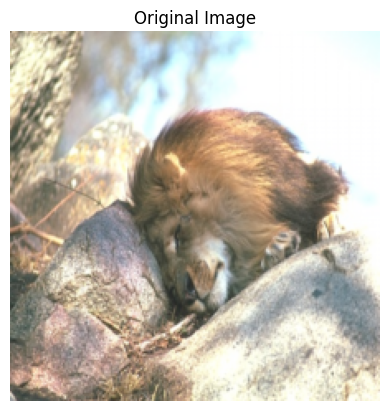

In [104]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

inv_normalize = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
])

labels=dataset.__getitemlabel__(4)
img_denormalized = inv_normalize(labels.clone())

img_np = img_denormalized.cpu().permute(1, 2, 0).numpy()

img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [87]:
import numpy as np
from PIL import Image
import math
import torch
import torch.nn as nn
import torchvision.transforms as transforms



def calculate_psnr(original_image, reconstructed_image):

    assert original_image.shape == reconstructed_image.shape, "Images must have the same dimensions"
    
    mse = np.mean((original_image - reconstructed_image) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr
    





PSNR value: 28.40 dB


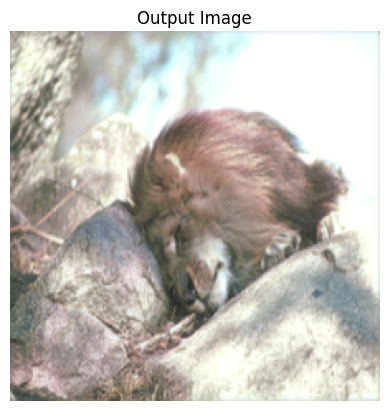

In [92]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

inv_normalize = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
])


labels=dataset.__getitemlabel__(4)
images=dataset.__getitemimage__(4)
outputs=model(images)

img_denormalized = inv_normalize(outputs.clone())
img_denormalized_labels=inv_normalize(labels.clone())

img_np = img_denormalized.detach().cpu().permute(1, 2, 0).numpy()
img_np_labels=img_denormalized_labels.detach().cpu().permute(1,2,0).numpy()

img_np = np.clip(img_np, 0, 1)
img_np_labels=np.clip(img_np_labels,0,1)

psnr_value = calculate_psnr(img_np_labels, img_np)
print(f"PSNR value: {psnr_value:.2f} dB")

plt.imshow(img_np)
plt.title('Output Image')
plt.axis('off')
plt.show()

In [ ]:
# Testing

In [93]:
dataset=FSRCNN_data('BSD100/image_SRF_4')

Epoch 0, Loss: 0.46366962358355523
Epoch 1, Loss: 0.29931101121008397
Epoch 2, Loss: 0.26812989994883535
Epoch 3, Loss: 0.2615172652900219
Epoch 4, Loss: 0.2682925856113434
Epoch 5, Loss: 0.24669792376458644
Epoch 6, Loss: 0.24113642156124115
Epoch 7, Loss: 0.23847711578011513
Epoch 8, Loss: 0.2246733670681715
Epoch 9, Loss: 0.22322296299040317
Epoch 10, Loss: 0.22195991680026053
Epoch 11, Loss: 0.22971036441624165
Epoch 12, Loss: 0.2227124959230423
Epoch 13, Loss: 0.22015806920826436
Epoch 14, Loss: 0.22214905455708503
Epoch 15, Loss: 0.22390880830585957
Epoch 16, Loss: 0.22476735353469848
Epoch 17, Loss: 0.21715980403125287
Epoch 18, Loss: 0.2150138346105814
Epoch 19, Loss: 0.21250114805996417


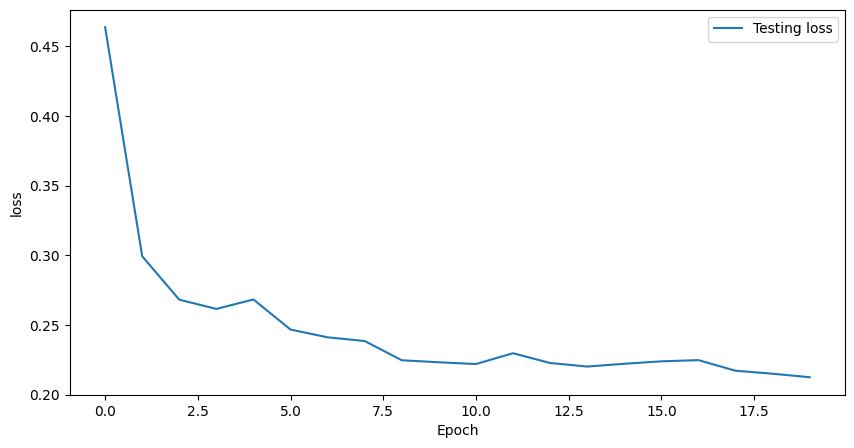

In [94]:
model=SRCNN_model()
mse_loss=nn.MSELoss()
perceptual_loss=VGGperceptualLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

epochs=20
batch_size=1
testing_loss=[]

for i in range(epochs):
    running_loss=0.0
    for j in range(100):
        
        images=dataset.__getitemimage__(j)
        labels=dataset.__getitemlabel__(j)
        optimizer.zero_grad()
        outputs=model(images)
        mse=mse_loss(outputs,labels)
        perceptual=perceptual_loss(outputs,labels)
        total_loss=mse+0.1*perceptual
        
        total_loss.backward()
        optimizer.step()
        running_loss+=total_loss.item()
        
    testing_loss.append(running_loss/100)
   
    print(f'Epoch {i}, Loss: {running_loss/100}' )
    
plt.figure(figsize=(10,5))
plt.plot(testing_loss,label="Testing loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

PSNR value: 28.09 dB


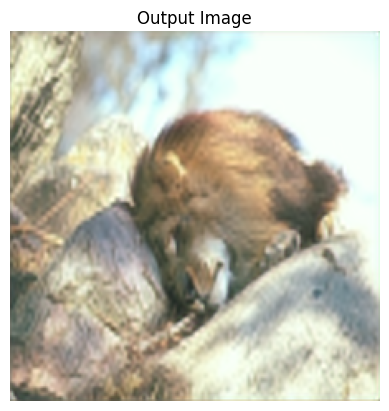

In [99]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

inv_normalize = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
])


labels=dataset.__getitemlabel__(4)
images=dataset.__getitemimage__(4)
outputs=model(images)

img_denormalized = inv_normalize(outputs.clone())
img_denormalized_labels=inv_normalize(labels.clone())

img_np = img_denormalized.detach().cpu().permute(1, 2, 0).numpy()
img_np_labels=img_denormalized_labels.detach().cpu().permute(1,2,0).numpy()

img_np = np.clip(img_np, 0, 1)
img_np_labels=np.clip(img_np_labels,0,1)

psnr_value = calculate_psnr(img_np_labels, img_np)
print(f"PSNR value: {psnr_value:.2f} dB")

plt.imshow(img_np)
plt.title('Output Image')
plt.axis('off')
plt.show()